In [72]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np

In [73]:
#Data collection
key = 'd6b98796604f0a274178f2bb5663fa6698b3cdf1'
df = pdr.get_data_tiingo('AAPL', api_key = key)


In [74]:
df.to_csv('Apple.csv')

In [75]:
df = pd.read_csv('Apple.csv')

In [76]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-01-05 00:00:00+00:00,102.71,105.85,102.41,105.75,55790992,23.786463,24.513651,23.716987,24.490493,223163968,0.0,1.0
1,AAPL,2016-01-06 00:00:00+00:00,100.70,102.37,99.87,100.56,68457388,23.320970,23.707723,23.128752,23.288548,273829552,0.0,1.0
2,AAPL,2016-01-07 00:00:00+00:00,96.45,100.13,96.43,98.68,81094428,22.336719,23.188965,22.332087,22.853161,324377712,0.0,1.0
3,AAPL,2016-01-08 00:00:00+00:00,96.96,99.11,96.76,98.55,70798016,22.454829,22.952744,22.408511,22.823055,283192064,0.0,1.0
4,AAPL,2016-01-11 00:00:00+00:00,98.53,99.06,97.34,98.97,49739377,22.818423,22.941165,22.542833,22.920322,198957508,0.0,1.0


In [77]:
df.tail() #Our dataset has values from January 2016 to December 2020

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2020-12-24 00:00:00+00:00,131.97,133.460,131.1000,131.32,54930064,131.97,133.460,131.1000,131.32,54930064,0.0,1.0
1254,AAPL,2020-12-28 00:00:00+00:00,136.69,137.340,133.5100,133.99,123124632,136.69,137.340,133.5100,133.99,123124632,0.0,1.0
1255,AAPL,2020-12-29 00:00:00+00:00,134.87,138.789,134.3409,138.05,121047324,134.87,138.789,134.3409,138.05,121047324,0.0,1.0
1256,AAPL,2020-12-30 00:00:00+00:00,133.72,135.990,133.4000,135.58,96452124,133.72,135.990,133.4000,135.58,96452124,0.0,1.0
1257,AAPL,2020-12-31 00:00:00+00:00,132.69,134.740,131.7200,134.08,99116586,132.69,134.740,131.7200,134.08,99116586,0.0,1.0


In [78]:
df_close = df.reset_index()['close']
df_close

0       102.71
1       100.70
2        96.45
3        96.96
4        98.53
         ...  
1253    131.97
1254    136.69
1255    134.87
1256    133.72
1257    132.69
Name: close, Length: 1258, dtype: float64

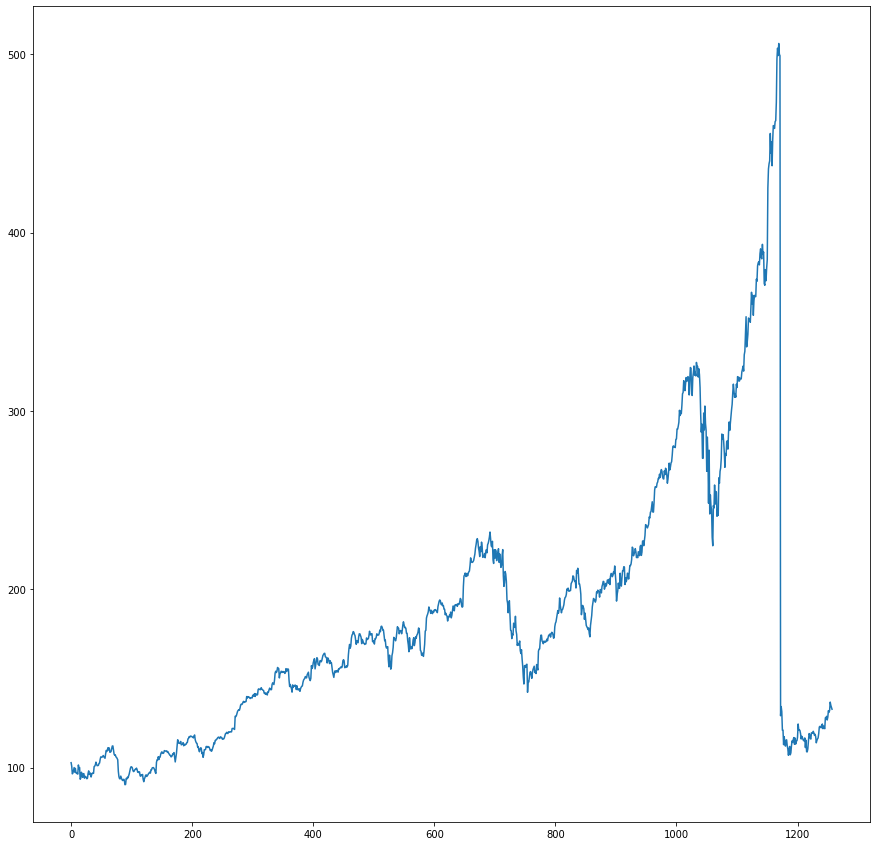

In [79]:
import matplotlib.pyplot as plt
plt.plot(df_close)

In [80]:
#Using min max scalar to rescale the data since lstm are sensitive to scale of the data

In [81]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [82]:
df_close

array([[0.02975346],
       [0.02491882],
       [0.01469633],
       ...,
       [0.10710764],
       [0.10434155],
       [0.1018641 ]])

In [83]:
#Since stock prices are related with their previous day value, we can't use normal train_test split 

In [84]:
train_size = int(len(df_close) * 0.70)
test_size = len(df_close) - train_size
train_data,test_data = df_close[0:train_size,:],df_close[train_size:len(df_close),:1]

In [85]:
def create_dataset(dataset, time_step = 1):
    
    dataX , dataY = [] , []
    for i in range(len(dataset) - time_step - 1):
        temp = dataset[i:(i+time_step), 0]
        dataX.append(temp)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
    

In [86]:
time_step = 120
X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [87]:
#Reshaping the data to fit our lstm model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [88]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [89]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(120,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')

In [90]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 120, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 120, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [91]:
history = model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
12/12 [==============================] - 3s 251ms/step - loss: 0.0108 - val_loss: 0.0580
Epoch 2/100
12/12 [==============================] - 2s 160ms/step - loss: 0.0022 - val_loss: 0.0288
Epoch 3/100
12/12 [==============================] - 2s 132ms/step - loss: 0.0011 - val_loss: 0.0274
Epoch 4/100
12/12 [==============================] - 2s 147ms/step - loss: 4.8659e-04 - val_loss: 0.0253
Epoch 5/100
12/12 [==============================] - 2s 150ms/step - loss: 3.9709e-04 - val_loss: 0.0249
Epoch 6/100
12/12 [==============================] - 2s 133ms/step - loss: 3.5703e-04 - val_loss: 0.0241
Epoch 7/100
12/12 [==============================] - 2s 134ms/step - loss: 3.5079e-04 - val_loss: 0.0237
Epoch 8/100
12/12 [==============================] - 2s 131ms/step - loss: 3.4192e-04 - val_loss: 0.0233
Epoch 9/100
12/12 [==============================] - 2s 132ms/step - loss: 3.3377e-04 - val_loss: 0.0228
Epoch 10/100
12/12 [==============================] - 2s 133ms/step

12/12 [==============================] - 2s 132ms/step - loss: 1.1920e-04 - val_loss: 0.0104
Epoch 79/100
12/12 [==============================] - 2s 131ms/step - loss: 1.1283e-04 - val_loss: 0.0099
Epoch 80/100
12/12 [==============================] - 2s 132ms/step - loss: 1.1301e-04 - val_loss: 0.0103
Epoch 81/100
12/12 [==============================] - 2s 130ms/step - loss: 1.1517e-04 - val_loss: 0.0110
Epoch 82/100
12/12 [==============================] - 2s 133ms/step - loss: 1.0999e-04 - val_loss: 0.0109
Epoch 83/100
12/12 [==============================] - 2s 131ms/step - loss: 1.0996e-04 - val_loss: 0.0104
Epoch 84/100
12/12 [==============================] - 2s 136ms/step - loss: 1.0763e-04 - val_loss: 0.0105
Epoch 85/100
12/12 [==============================] - 2s 131ms/step - loss: 1.0958e-04 - val_loss: 0.0096
Epoch 86/100
12/12 [==============================] - 2s 132ms/step - loss: 1.2117e-04 - val_loss: 0.0092
Epoch 87/100
12/12 [==============================] - 2s 13

In [92]:
import tensorflow as tf

In [93]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
##Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [94]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict)) #Will obviously be better than test rmse

166.28628626322433

In [95]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

273.5785908501695

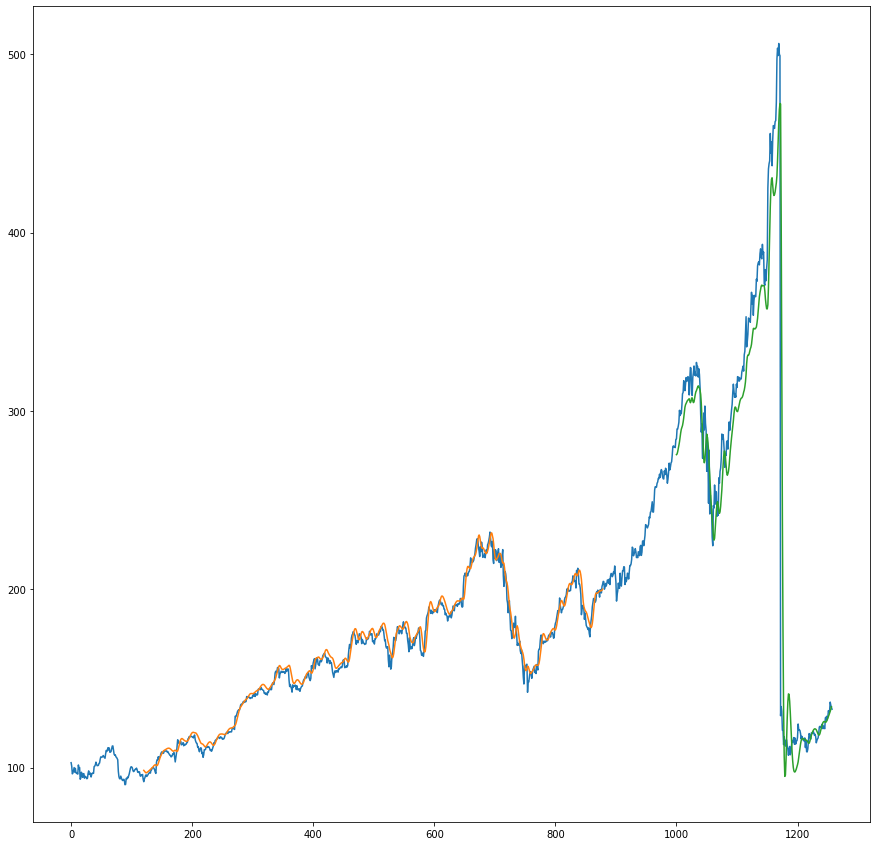

In [96]:
### Plotting 
# shift train predictions for plotting
plt.rcParams['figure.figsize'] = [15, 15] #Increases the size of the plotted graph
look_back=120
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show() #Green : test, Orange: train, blue: actual

In [97]:
len(test_data)

378

In [98]:
x_input=test_data[258:].reshape(1,-1)
x_input.shape

(1, 120)

In [99]:
#Storing prev 120 days data in temp_input. We will need this to predict price for (present + 1) day
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.7165123271196634,
 0.7229344558027659,
 0.7113650030066145,
 0.7094888755261575,
 0.7290198436560433,
 0.7159591100420926,
 0.7185808779314491,
 0.6759831629585087,
 0.673770294648226,
 0.6948887552615755,
 0.6799037883343355,
 0.6971016235718581,
 0.7081659651232712,
 0.8050511124473845,
 0.830811785929044,
 0.8378111846061336,
 0.841635598316296,
 0.8785808779314492,
 0.8517378232110644,
 0.8672760072158752,
 0.8350210463018641,
 0.8699939867708961,
 0.8892363199037885,
 0.8882501503307276,
 0.8853638003607938,
 0.89455201443175,
 0.8959470835838845,
 0.9206494287432352,
 0.9792904389657247,
 0.9936019242333134,
 0.9836680697534577,
 1.0,
 0.9854479855682503,
 0.983499699338545,
 0.09308478653036678,
 0.10544798556825014,
 0.09876127480457003,
 0.07345760673481655,
 0.07365003006614551,
 0.05407095610342749,
 0.06489476849067943,
 0.055682501503307225,
 0.052098616957306054,
 0.0601683704149128,
 0.06061334936861096,
 0.05241130487071555,
 0.04810583283223091,
 0.03968731208659049

In [100]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=120
i=0
while(i<30):
    
    if(len(temp_input)>120):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        
print(lst_output)

[0.10896941]
121
1 day input [0.72293446 0.711365   0.70948888 0.72901984 0.71595911 0.71858088
 0.67598316 0.67377029 0.69488876 0.67990379 0.69710162 0.70816597
 0.80505111 0.83081179 0.83781118 0.8416356  0.87858088 0.85173782
 0.86727601 0.83502105 0.86999399 0.88923632 0.88825015 0.8853638
 0.89455201 0.89594708 0.92064943 0.97929044 0.99360192 0.98366807
 1.         0.98544799 0.9834997  0.09308479 0.10544799 0.09876127
 0.07345761 0.07365003 0.05407096 0.06489477 0.0556825  0.05209862
 0.06016837 0.06061335 0.0524113  0.04810583 0.03968731 0.04748046
 0.05164161 0.04036079 0.04300661 0.0527721  0.05921828 0.05712568
 0.06126278 0.06361996 0.05455201 0.06292243 0.05488876 0.05950692
 0.05924233 0.06405292 0.08192423 0.07398677 0.07420325 0.07304871
 0.06898376 0.06167168 0.06535177 0.06381239 0.06111846 0.0594107
 0.05943476 0.06316296 0.05017438 0.06008419 0.044546   0.04432952
 0.04834636 0.05919423 0.06900782 0.06819002 0.06248948 0.06164762
 0.07011425 0.06944077 0.06956103 0

6 day output [[0.1144652]]
7 day input [0.67598316 0.67377029 0.69488876 0.67990379 0.69710162 0.70816597
 0.80505111 0.83081179 0.83781118 0.8416356  0.87858088 0.85173782
 0.86727601 0.83502105 0.86999399 0.88923632 0.88825015 0.8853638
 0.89455201 0.89594708 0.92064943 0.97929044 0.99360192 0.98366807
 1.         0.98544799 0.9834997  0.09308479 0.10544799 0.09876127
 0.07345761 0.07365003 0.05407096 0.06489477 0.0556825  0.05209862
 0.06016837 0.06061335 0.0524113  0.04810583 0.03968731 0.04748046
 0.05164161 0.04036079 0.04300661 0.0527721  0.05921828 0.05712568
 0.06126278 0.06361996 0.05455201 0.06292243 0.05488876 0.05950692
 0.05924233 0.06405292 0.08192423 0.07398677 0.07420325 0.07304871
 0.06898376 0.06167168 0.06535177 0.06381239 0.06111846 0.0594107
 0.05943476 0.06316296 0.05017438 0.06008419 0.044546   0.04432952
 0.04834636 0.05919423 0.06900782 0.06819002 0.06248948 0.06164762
 0.07011425 0.06944077 0.06956103 0.07206254 0.06987372 0.06660253
 0.06806975 0.06494287 0.

12 day output [[0.12199967]]
13 day input [0.80505111 0.83081179 0.83781118 0.8416356  0.87858088 0.85173782
 0.86727601 0.83502105 0.86999399 0.88923632 0.88825015 0.8853638
 0.89455201 0.89594708 0.92064943 0.97929044 0.99360192 0.98366807
 1.         0.98544799 0.9834997  0.09308479 0.10544799 0.09876127
 0.07345761 0.07365003 0.05407096 0.06489477 0.0556825  0.05209862
 0.06016837 0.06061335 0.0524113  0.04810583 0.03968731 0.04748046
 0.05164161 0.04036079 0.04300661 0.0527721  0.05921828 0.05712568
 0.06126278 0.06361996 0.05455201 0.06292243 0.05488876 0.05950692
 0.05924233 0.06405292 0.08192423 0.07398677 0.07420325 0.07304871
 0.06898376 0.06167168 0.06535177 0.06381239 0.06111846 0.0594107
 0.05943476 0.06316296 0.05017438 0.06008419 0.044546   0.04432952
 0.04834636 0.05919423 0.06900782 0.06819002 0.06248948 0.06164762
 0.07011425 0.06944077 0.06956103 0.07206254 0.06987372 0.06660253
 0.06806975 0.06494287 0.05654841 0.05972339 0.06179194 0.06313891
 0.06905592 0.07788334

18 day output [[0.13061357]]
19 day input [0.86727601 0.83502105 0.86999399 0.88923632 0.88825015 0.8853638
 0.89455201 0.89594708 0.92064943 0.97929044 0.99360192 0.98366807
 1.         0.98544799 0.9834997  0.09308479 0.10544799 0.09876127
 0.07345761 0.07365003 0.05407096 0.06489477 0.0556825  0.05209862
 0.06016837 0.06061335 0.0524113  0.04810583 0.03968731 0.04748046
 0.05164161 0.04036079 0.04300661 0.0527721  0.05921828 0.05712568
 0.06126278 0.06361996 0.05455201 0.06292243 0.05488876 0.05950692
 0.05924233 0.06405292 0.08192423 0.07398677 0.07420325 0.07304871
 0.06898376 0.06167168 0.06535177 0.06381239 0.06111846 0.0594107
 0.05943476 0.06316296 0.05017438 0.06008419 0.044546   0.04432952
 0.04834636 0.05919423 0.06900782 0.06819002 0.06248948 0.06164762
 0.07011425 0.06944077 0.06956103 0.07206254 0.06987372 0.06660253
 0.06806975 0.06494287 0.05654841 0.05972339 0.06179194 0.06313891
 0.06905592 0.07788334 0.07874925 0.07841251 0.07675286 0.08036079
 0.08187613 0.07562237

24 day output [[0.13937093]]
25 day input [0.89455201 0.89594708 0.92064943 0.97929044 0.99360192 0.98366807
 1.         0.98544799 0.9834997  0.09308479 0.10544799 0.09876127
 0.07345761 0.07365003 0.05407096 0.06489477 0.0556825  0.05209862
 0.06016837 0.06061335 0.0524113  0.04810583 0.03968731 0.04748046
 0.05164161 0.04036079 0.04300661 0.0527721  0.05921828 0.05712568
 0.06126278 0.06361996 0.05455201 0.06292243 0.05488876 0.05950692
 0.05924233 0.06405292 0.08192423 0.07398677 0.07420325 0.07304871
 0.06898376 0.06167168 0.06535177 0.06381239 0.06111846 0.0594107
 0.05943476 0.06316296 0.05017438 0.06008419 0.044546   0.04432952
 0.04834636 0.05919423 0.06900782 0.06819002 0.06248948 0.06164762
 0.07011425 0.06944077 0.06956103 0.07206254 0.06987372 0.06660253
 0.06806975 0.06494287 0.05654841 0.05972339 0.06179194 0.06313891
 0.06905592 0.07788334 0.07874925 0.07841251 0.07675286 0.08036079
 0.08187613 0.07562237 0.0791341  0.0771377  0.07562237 0.09029465
 0.09012628 0.0922669

In [101]:
day_new = np.arange(1,121)
day_pred = np.arange(121,151)

In [102]:
len(df_close)

1258

In [103]:
df3 = df_close.tolist()
df3.extend(lst_output)


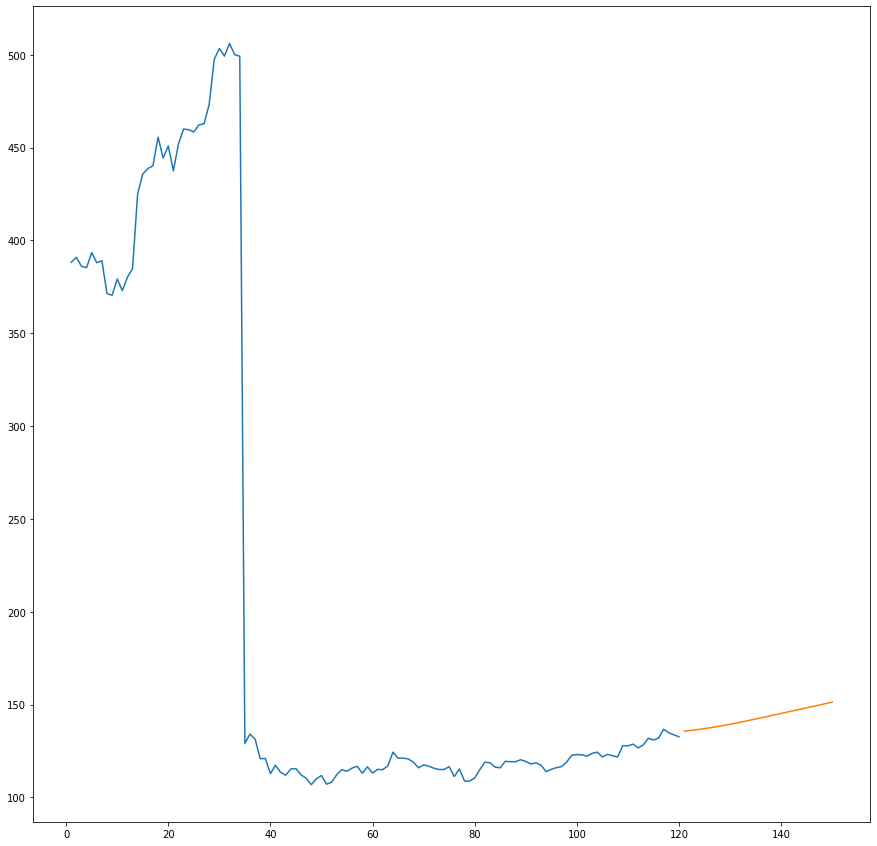

In [105]:
plt.plot(day_new,scaler.inverse_transform(df_close[1138:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
#Orange line shows the predicted closing price for the next 30 days